In [ ]:
%pip install sdv=='0.18.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)
import matplotlib.pyplot as plt
import datetime
import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sdv.timeseries import PAR # Synthetic Data Vault
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from numpy.random import uniform
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_error
from statistics import median
from math import sqrt
from sklearn.metrics import r2_score
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

Tensorflow Version:  2.12.0


/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


In [ ]:
df = pd.read_csv('CME.csv')
df.head()

,disturbance,transit_time,angular_width,MPA,avg_speed,final_speed,mass,BX,BZ_GSE,Plasma_Temp,Plasma_Speed,Plasma_flow_long,Alpha_Prot_ratio,flow_pressure
0,1996-08-14 19:30:00,36.0,235.0,237.0,691.0,394.0,3.100000e+15,-4.7,0.6,99883,480,0.9,0.040,2.59
1,1996-11-28 16:50:00,89.0,101.0,267.0,984.0,1180.0,4.000000e+15,-4.2,-0.9,31127,397,0.9,0.008,2.01
2,1996-12-19 16:30:00,95.0,130.0,265.0,469.0,394.0,5.100000e+14,0.4,0.1,14435,323,-3.3,0.006,0.87
3,1997-01-06 15:10:00,81.0,360.0,180.0,136.0,224.0,5.800000e+14,3.0,1.8,35501,367,-1.4,0.011,2.75
4,1997-02-07 00:30:00,60.0,360.0,266.0,490.0,718.0,4.100000e+15,1.8,2.3,34874,375,0.6,0.022,1.23


## Pre-processing

### Converting Data Type

In [ ]:
def str_to_datatime(row):
    x = datetime.datetime.strptime(row,'%Y-%m-%d %H:%M:%S')
    return x

In [ ]:
df["disturbance"] = [str_to_datatime(x) for x in df["disturbance"]]

### SDV

In [ ]:
sequence_index = 'disturbance'
generator = PAR(sequence_index=sequence_index)
generator.fit(df)

In [ ]:
new_data = generator.sample(1)
new_data.head()

,disturbance,transit_time,angular_width,MPA,avg_speed,final_speed,mass,BX,BZ_GSE,Plasma_Temp,Plasma_Speed,Plasma_flow_long,Alpha_Prot_ratio,flow_pressure
0,1996-08-14 19:30:00,69.761932,256.481280,184.297521,1664.738190,901.622590,-4.307885e+15,2.960114,-0.646013,100292,582,0.735387,0.045221,2.400618
1,1996-09-08 15:22:16,64.964187,298.063444,230.651283,589.588063,1055.659956,1.992062e+16,3.500571,-0.613720,100292,586,-0.482415,0.041395,4.785392
2,1996-11-05 17:39:07,46.671745,386.680234,43.582014,133.166669,624.518789,4.993740e+15,2.534098,-1.848403,-35659,468,0.183912,0.013201,6.239392
3,1996-12-07 09:44:11,105.184107,296.443243,343.356018,730.636457,1001.505235,2.607456e+16,-1.953216,0.990690,64156,385,-3.166432,0.021892,0.964409
4,1997-02-04 17:16:21,55.342272,204.519515,322.115754,832.259617,1105.401604,-2.583823e+14,1.507015,-2.300022,-30524,406,1.526540,0.054098,0.916627


In [ ]:
# date as index
df = df.set_index('disturbance')
df.index = pd.to_datetime(df.index, unit='ns')

In [ ]:
df = pd.concat([df, new_data])

### Feature Selection

In [ ]:
desired_columns = ['angular_width', 'MPA', 'avg_speed', 'final_speed', 'BX', 'flow_pressure']
target_columns = ['transit_time']

feature = df[desired_columns]
target = df[target_columns]

### Data splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.7, shuffle=False)

## Models

### MLP

In [ ]:
def MLP (hidden_layers, neurons, learning_rate):
  MLP_model = tf.keras.models.Sequential()

  for i in range(hidden_layers):
    layer = tf.keras.layers.Dense(neurons, activation='relu')
    MLP_model.add(layer)

  output_layer = tf.keras.layers.Dense(1, activation='relu')
  MLP_model.add(output_layer)

  MLP_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss='mse', metrics=['mean_absolute_error'])

  return MLP_model

### LSTM

In [ ]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

X_train.shape
X_test.shape

(509, 1, 6)

In [ ]:
def LSTM (hidden_layers, neurons, learning_rate):

  LSTM_model = tf.keras.models.Sequential()

  for i in range(hidden_layers):
    LSTM_layer = tf.keras.layers.LSTM(neurons, return_sequences=True)
    LSTM_model.add(LSTM_layer)

  output_layer = tf.keras.layers.Dense(1, activation='relu')
  LSTM_model.add(output_layer)

  LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                     loss='mse', metrics=['mean_absolute_error'])

  return LSTM_model

### Predictor of predictors

#### New data splitting

In [ ]:
# determining the test data as suggested by Alobaid
year = 2014
year_next = str(year+1)
year = str(year)
test_indices = df.index[(df['disturbance'] >= datetime.datetime.fromisoformat(year+'-01-01 00:00:00')) &
                        (df['disturbance'] < datetime.datetime.fromisoformat(year_next+'-01-01 00:00:00'))].tolist()

In [ ]:
data = df[:]
data = data.drop(test_indices)
data.drop("disturbance", axis=1, inplace=True)

X_data = data[:]
X_data.drop("transit_time", axis=1, inplace=True)

y_data = data['transit_time']

In [ ]:
data_shape = X_data.shape[1]
test_data = new_data.iloc[test_indices, :]
events_disturbance = test_data["disturbance"].reset_index(drop=True)
test_data.drop("disturbance", axis=1, inplace=True)

In [ ]:
X_test = test_data[:]
X_test.drop("transit_time", axis=1, inplace=True)
y_test = test_data['transit_time']
y_test = y_test.reset_index(drop=True)

#### Join

In [ ]:
SVR_model = SVR(kernel='rbf', cache_size=200)
XGBoost_model = XGBRegressor()
kernel = 1.0 * RBF() + WhiteKernel(noise_level=0.2)
GPR_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)

In [ ]:
training_times = 150

MAE_temp = 100
MAE_SVR_temp = 100
MAE_XGBoost_temp = 100
MAE_GPR_temp = 100

In [ ]:
report_each = 1

for i in range(1, training_times+1):
    if i % report_each == 0:
        print("Epoch ", str(i).zfill(2), "/" + str(training_times))

    SVR_X_train, SVR_X_test, SVR_y_train, SVR_y_test = train_test_split(X_data, y_data, test_size=0.7)
    SVR = SVR_model
    SVR_result = SVR.fit(SVR_X_train, SVR_y_train).predict(X_test)

    XGBoost_X_train, XGBoost_X_test, XGBoost_y_train, XGBoost_y_test = train_test_split(X_data, y_data, test_size=0.7)
    XGBoost = XGBoost_model
    XGBoost_result = XGBoost.fit(XGBoost_X_train, XGBoost_y_train).predict(X_test)

    GPR_X_train, GPR_X_test, GPR_y_train, GPR_y_test = train_test_split(X_data, y_data, test_size=0.7)
    GPR = GPR_model
    GPR_result = GPR.fit(GPR_X_train, GPR_y_train).predict(X_test)

    MAE_SVR_current = round(mean_absolute_error(y_test, SVR_result),2)
    if MAE_SVR_current < MAE_SVR_temp: # defined as 100
        best_SVR_result = SVR_result
        best_SVR = SVR
        MAE_SVR_temp = MAE_SVR_current
        best_SVR_X_train = SVR_X_train

    MAE_XGBoost_current = round(mean_absolute_error(y_test, XGBoost_result),2)
    if MAE_XGBoost_current < MAE_XGBoost_temp: # defined as 100
        best_XGBoost_result = XGBoost_result
        best_XGBoost = XGBoost
        MAE_XGBoost_temp = MAE_XGBoost_current
        best_XGBoost_X_train = XGBoost_X_train

    MAE_GPR_current = round(mean_absolute_error(y_test, GPR_result),2)
    if MAE_GPR_current < MAE_GPR_temp: # defined as 100
        best_GPR_result = GPR_result
        best_GPR = GPR
        MAE_GPR_temp = MAE_GPR_current
        best_GPR_X_train = GPR_X_train


    median_results = []
    all_results = []

    for x in range(0, len(y_test)):
        x1 = best_SVR_result[x]
        x2 = best_XGBoost_result[x]
        x3 = best_GPR_result[x]
        all_results = [x1,x2,x3]
        median_results.append(median(all_results))
        all_results.append(all_results)

    # saving metrics
    MAE_PP = []
    MSE_PP = []
    RMSE_PP = []

    MAE_PP.append(np.mean(tf.keras.metrics.mean_absolute_error(y_test, median_results)))
    MSE_PP = np.mean(tf.keras.metrics.mean_squared_error(y_test, median_results))
    RMSE_PP = sqrt(MSE_PP)


    # deleting for the next round
    del SVR
    del XGBoost
    del GPR

Epoch  01 /150
Epoch  02 /150
Epoch  03 /150
Epoch  04 /150
Epoch  05 /150
Epoch  06 /150
Epoch  07 /150
Epoch  08 /150
Epoch  09 /150
Epoch  10 /150
Epoch  11 /150
Epoch  12 /150
Epoch  13 /150
Epoch  14 /150
Epoch  15 /150
Epoch  16 /150
Epoch  17 /150
Epoch  18 /150
Epoch  19 /150
Epoch  20 /150
Epoch  21 /150
Epoch  22 /150
Epoch  23 /150
Epoch  24 /150
Epoch  25 /150
Epoch  26 /150
Epoch  27 /150
Epoch  28 /150
Epoch  29 /150
Epoch  30 /150
Epoch  31 /150
Epoch  32 /150
Epoch  33 /150
Epoch  34 /150
Epoch  35 /150
Epoch  36 /150
Epoch  37 /150
Epoch  38 /150
Epoch  39 /150
Epoch  40 /150
Epoch  41 /150
Epoch  42 /150
Epoch  43 /150
Epoch  44 /150
Epoch  45 /150
Epoch  46 /150
Epoch  47 /150
Epoch  48 /150
Epoch  49 /150
Epoch  50 /150
Epoch  51 /150
Epoch  52 /150
Epoch  53 /150
Epoch  54 /150
Epoch  55 /150
Epoch  56 /150
Epoch  57 /150
Epoch  58 /150
Epoch  59 /150
Epoch  60 /150
Epoch  61 /150
Epoch  62 /150
Epoch  63 /150
Epoch  64 /150
Epoch  65 /150
Epoch  66 /150
Epoch  67 

In [ ]:
np.mean(RMSE_PP)

15.910075868456046

## Optimization

### Increasing Window Cross Validation

In [ ]:
def iwcv (model, X_train, y_train):
  tscv = TimeSeriesSplit(n_splits=3)
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', min_delta=0.2, patience=20, mode="min", start_from_epoch=100)
  metrics = []

  for idx_train, idx_validation in tscv.split(X_train):
    model.fit(X_train[idx_train], y_train.iloc[idx_train], epochs=300, callbacks=[early_stopping], validation_split=0.2)
    y_pred = model.predict(X_train[idx_validation])

    MAE = np.mean(tf.keras.metrics.mean_absolute_error(y_train.iloc[idx_validation], y_pred))
    MSE = np.mean(tf.keras.metrics.mean_squared_error(y_train.iloc[idx_validation], y_pred))
    RMSE = math.sqrt(MSE)

    metrics.append([MAE, MSE, RMSE, len(X_train[idx_train][0]), len(X_train[idx_validation][0])])

  return metrics

In [ ]:
def avg (metrics):
  avg_MAE = []
  avg_MSE = []
  avg_RMSE = []

  for i,j in enumerate(metrics):
    avg_MAE.append(j[0])
    avg_MSE.append(j[1])
    avg_RMSE.append(j[2])

  avg_MAE = sum(avg_MAE)/len(avg_MAE)
  avg_MSE = sum(avg_MSE)/len(avg_MSE)
  avg_RMSE = sum(avg_RMSE)/len(avg_RMSE)

  return avg_MAE,avg_MSE,avg_RMSE

### Grid Search

In [ ]:
def grid_search (model, hidden_layers, neurons, learning_rate):
  parameters = []

  if (model == MLP):
    for i in hidden_layers:
      for j in neurons:
        for k in learning_rate:
          model = MLP(i,j,k)
          metrics = iwcv(model, X_train, y_train)
          avg_MAE, avg_MSE, avg_RMSE = avg(metrics)
          parameters.append([i,j,k,metrics,avg_MAE,avg_MSE,avg_RMSE])
  elif (model == LSTM):
    for i in hidden_layers:
      for j in neurons:
        for k in learning_rate:
          model = LSTM(i,j,k)
          metrics = iwcv(model, X_train, y_train)
          avg_MAE, avg_MSE, avg_RMSE = avg(metrics)
          parameters.append([i,j,k,metrics,avg_MAE,avg_MSE,avg_RMSE])
  else:
    print("Selecione um modelo válido")

  return parameters

In [ ]:
hidden_layers = [2,4,6]
neurons = [30,50,70,90]
learning_rate = [0.01, 0.005]
parameters = grid_search(LSTM, hidden_layers, neurons, learning_rate)

Streaming output truncated to the last 5000 lines.
Epoch 42/300
5/5 [==============================] - 0s 19ms/step - loss: 334.5073 - mean_absolute_error: 15.1462 - val_loss: 369.6057 - val_mean_absolute_error: 15.4073
Epoch 43/300
5/5 [==============================] - 0s 19ms/step - loss: 334.5298 - mean_absolute_error: 15.1466 - val_loss: 370.1221 - val_mean_absolute_error: 15.4187
Epoch 44/300
5/5 [==============================] - 0s 21ms/step - loss: 334.5683 - mean_absolute_error: 15.1460 - val_loss: 370.5254 - val_mean_absolute_error: 15.4277
Epoch 45/300
5/5 [==============================] - 0s 18ms/step - loss: 334.6540 - mean_absolute_error: 15.1471 - val_loss: 370.8834 - val_mean_absolute_error: 15.4355
Epoch 46/300
5/5 [==============================] - 0s 21ms/step - loss: 334.6051 - mean_absolute_error: 15.1462 - val_loss: 370.4902 - val_mean_absolute_error: 15.4269
Epoch 47/300
5/5 [==============================] - 0s 21ms/step - loss: 334.5651 - mean_absolute_error:

In [ ]:
parameters

[[2,
  30,
  0.01,
  [[14.726191, 324.9546, 18.026496882194, 1, 1],
   [16.870377, 425.27518, 20.622201070738136, 1, 1],
   [19.339859, 543.31647, 23.309149861913802, 1, 1]],
  16.978808720906574,
  431.1820780436198,
  20.65261593828198],
 [2,
  30,
  0.005,
  [[14.418542, 329.09015, 18.14084201259085, 1, 1],
   [15.931014, 381.49033, 19.531777336631052, 1, 1],
   [19.402523, 546.5337, 23.37806004368733, 1, 1]],
  16.584026336669922,
  419.0380554199219,
  20.350226464303077],
 [2,
  50,
  0.01,
  [[14.985275, 337.7301, 18.37743460168101, 1, 1],
   [16.863508, 424.92682, 20.613753148023683, 1, 1],
   [19.313372, 542.0129, 23.28117003971168, 1, 1]],
  17.054051717122395,
  434.8899332682292,
  20.757452596472124],
 [2,
  50,
  0.005,
  [[14.645704, 321.22656, 17.92279449472096, 1, 1],
   [16.878859, 425.6604, 20.63153897290808, 1, 1],
   [18.413998, 494.0832, 22.22798216028546, 1, 1]],
  16.64618682861328,
  413.65671793619794,
  20.2607718759715],
 [2,
  70,
  0.01,
  [[15.844305, 385

### Analyzing Hiperparemeters Results

In [ ]:
df_parameters = pd.DataFrame(parameters, columns=['hidden_layers', 'neurons', 'learning_rate', 'metrics', 'MAE_avg', 'MSE_avg', 'RMSE_avg'])
df_parameters

,hidden_layers,neurons,learning_rate,metrics,MAE_avg,MSE_avg,RMSE_avg
0,2,30,0.010,"[[14.726191, 324.9546, 18.026496882194, 1, 1],...",16.978809,431.182078,20.652616
1,2,30,0.005,"[[14.418542, 329.09015, 18.14084201259085, 1, ...",16.584026,419.038055,20.350226
2,2,50,0.010,"[[14.985275, 337.7301, 18.37743460168101, 1, 1...",17.054052,434.889933,20.757453
3,2,50,0.005,"[[14.645704, 321.22656, 17.92279449472096, 1, ...",16.646187,413.656718,20.260772
4,2,70,0.010,"[[15.844305, 385.64395, 19.637819416015, 1, 1]...",17.382870,452.937653,21.225268
5,2,70,0.005,"[[14.765649, 326.92957, 18.08119369482246, 1, ...",17.413289,460.926137,21.334119
6,2,90,0.010,"[[16.044374, 395.80612, 19.894876773334683, 1,...",17.678423,468.422312,21.565343
7,2,90,0.005,"[[65.07407, 4545.8794, 67.42313693778456, 1, 1...",58.478395,3757.726807,61.109337
8,4,30,0.010,"[[14.707002, 324.0122, 18.000339081007613, 1, ...",16.959691,430.208008,20.631136
9,4,30,0.005,"[[14.397183, 326.73694, 18.075866188832073, 1,...",16.615801,420.109619,20.370842


In [ ]:
df_parameters.to_csv('LSTM_CME_parameters.csv')

## Metrics

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018SW002046

In [ ]:
def metrics (y_test, y_pred):
  MAE = np.mean(tf.keras.metrics.mean_absolute_error(y_test, y_pred))
  MSE = np.mean(tf.keras.metrics.mean_squared_error(y_test, y_pred))
  RMSE = sqrt(MSE)

  return [MAE,MSE,RMSE]

In [ ]:
LSTM_model = LSTM(6,30,0.005)

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', min_delta=0.2, patience=20, mode="min", start_from_epoch=100)
LSTM_model.fit(X_train, y_train, epochs=300, validation_split=0.2)

y_pred = LSTM_model.predict(X_test)
result = metrics(y_test, y_pred)
print(result)

Epoch 1/300
6/6 [==============================] - 20s 536ms/step - loss: 4503.9927 - mean_absolute_error: 64.5317 - val_loss: 3177.6787 - val_mean_absolute_error: 52.7950
Epoch 2/300
6/6 [==============================] - 0s 25ms/step - loss: 4483.9780 - mean_absolute_error: 64.3759 - val_loss: 3141.8984 - val_mean_absolute_error: 52.4556
Epoch 3/300
6/6 [==============================] - 0s 24ms/step - loss: 4390.8589 - mean_absolute_error: 63.6559 - val_loss: 2957.3225 - val_mean_absolute_error: 50.6711
Epoch 4/300
6/6 [==============================] - 0s 24ms/step - loss: 4086.4683 - mean_absolute_error: 61.1946 - val_loss: 2670.5581 - val_mean_absolute_error: 47.7537
Epoch 5/300
6/6 [==============================] - 0s 21ms/step - loss: 3777.1785 - mean_absolute_error: 58.6185 - val_loss: 2488.5686 - val_mean_absolute_error: 45.8065
Epoch 6/300
6/6 [==============================] - 0s 25ms/step - loss: 3582.0295 - mean_absolute_error: 56.9497 - val_loss: 2368.7869 - val_mean_ab

Mean Absolute Error (MAE)

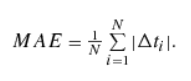

While the ME is a measure of the model's bias, it is not adequate to measure the forecasting skill of a model, since negative errors can compensate positive errors. By taking the absolute value of the errors and in fact measuring the distance between the observed and forecast values, we can compensate for this.

Mean Squared Error (MSE)

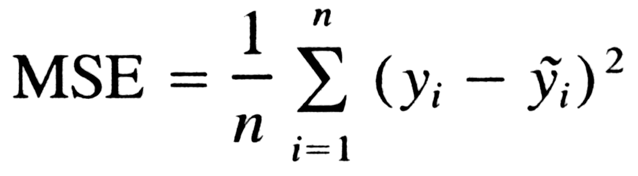

Rooted Mean Squared Error (RMSE)

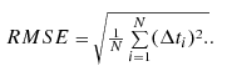

Compared to the MAE, the RMSE gives more weight to larger errors, due to the errors being squared.

For example, two errors of 1 hr, contribute the same error to MAE as one single error of 2 hr. However, the two 1-hr errors contribute less to RMSE than the one 2-hr error.

R²

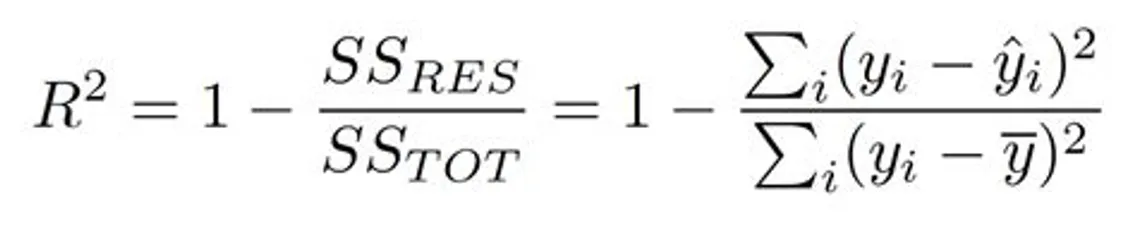

It tells how close are data to the fitted regression line.

* Highest score can be 1.0 and it indicates that the predictors perfectly accounts for variation in the target.
* Score 0.0 indicates that the predictors do not account for variation in the target.
* It can also be negative if the model is worse.

In [ ]:
R2_MLP = r2_score(y_test, MLP_pred)
R2_LSTM = r2_score(y_test, LSTM_pred)

ValueError: ignored

### Table

In [ ]:
table = [['MAE', 'MSE', 'RMSE'],
         [MAE_MLP, MSE_MLP, RMSE_MLP],
         [MAE_LSTM, MSE_LSTM, RMSE_LSTM],
         [MAE_PP, MSE_PP, RMSE_PP]]

In [ ]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════╤═════════╤═════════╕
│     MAE │     MSE │    RMSE │
╞═════════╪═════════╪═════════╡
│ 18.1361 │ 503.169 │ 21.6157 │
├─────────┼─────────┼─────────┤
│ 16.1949 │ 402.408 │ 19.6004 │
├─────────┼─────────┼─────────┤
│ 15.08   │ 312.372 │ 17.6741 │
╘═════════╧═════════╧═════════╛
